# Predicting Used Car Price using Linear Regression Model

## Initial Questions
Can we predict the price of used car from their specifications using Linear Regression Model?

## Let's find out!

### Import relevant libraries into the Environment

In [260]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import missingno as msno
sns.set()

### Load the dataset 

In [261]:
df=pd.read_csv("car price data.csv")
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


## Data Pre-processing

In [262]:
# Obtaining the descriptive statistics
df.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


As we can see above, there are **missing values** because the number of records are different for each column

## Determining the variables of interest

In [263]:
# Since the attribute model has a lot of variations (about 312), it is hard to use it in linear regression - Dummy variables
data = df.drop(["Model"],axis=1)
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011


## Dealing with missing values

In [264]:
len(data)

4345

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

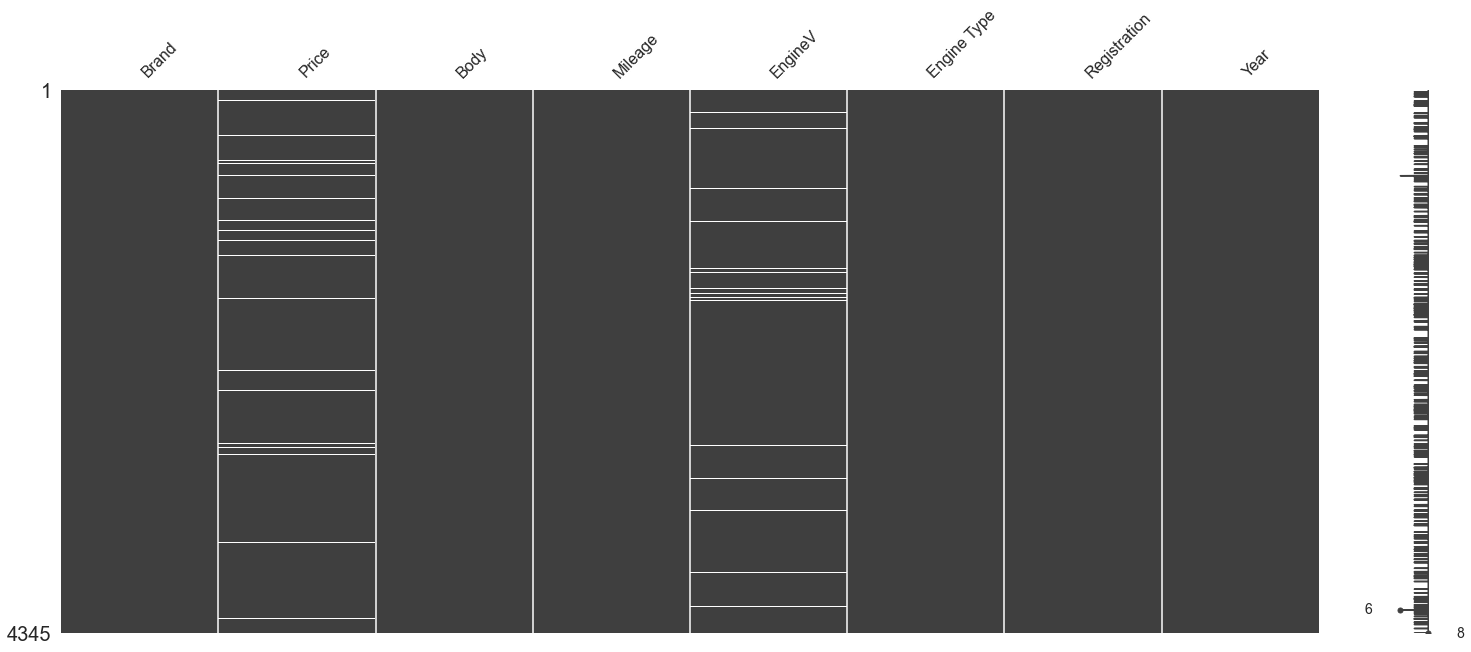

In [100]:
#Visualise and count the missing values
msno.matrix(data)
data.isnull().sum()

In [101]:
#Checking the percentage of missing values
(data.isnull().sum()/4345)*100

Brand           0.000000
Price           3.958573
Body            0.000000
Mileage         0.000000
EngineV         3.452244
Engine Type     0.000000
Registration    0.000000
Year            0.000000
dtype: float64

In [102]:
#Since they are less than 5%, we can just omit it. 
data= data.dropna(axis=0, how="any")
# Checking the percentage of data available after dropping
(len(data)/4345)*100

92.63521288837745

In [103]:
data.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,4025,4025.000000,4025,4025.000000,4025.000000,4025,4025,4025.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1534,NaN,NaN,1861,3654,NaN
mean,NaN,19552.308065,NaN,163.572174,2.764586,NaN,NaN,2006.379627
std,NaN,25815.734988,NaN,103.394703,4.935941,NaN,NaN,6.695595
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21900.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000


### Exploring Probability Distribution Functions



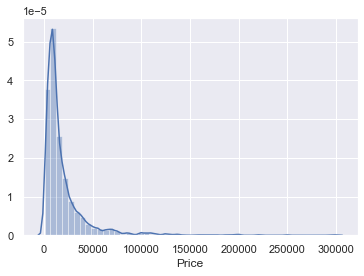

In [104]:
#Check for the variable of interest
# The PDF will show us how that variable is distributed 
# This makes it very easy to spot anomalies, such as outliers
# The PDF is often the basis on which we decide whether we want to transform a feature
sns.distplot(data["Price"])

Optimal results should have normal distribution. As we can see above, there are few outliers. The variable are highly distributed between 0 to 100K. This will affect the **Regression Modeling** dramatically later on. This is because the regression model will try to place the line close to those values. So we need to remove top 1% of the records

### Dealing with the outliers

In [105]:
# We need to remove 0.5%, or 1% of the problematic samples
# The outliers are situated around the higher prices (right side of the graph)
# Logically, one can imagine how $300,000 is an excessive price for used car!!! So we can omit it.

# Declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = data['Price'].quantile(0.99)
# Creating new df, with the condition that all prices must be below the 99 percentile of 'Price'
df= data.loc[data["Price"]<q,:]
df.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3984,3984.000000,3984,3984.000000,3984.000000,3984,3984,3984.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1528,NaN,NaN,1853,3613,NaN
mean,NaN,17837.117460,NaN,165.116466,2.743770,NaN,NaN,2006.292922
std,NaN,18976.268315,NaN,102.766126,4.956057,NaN,NaN,6.672745
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6980.000000,NaN,93.000000,1.800000,NaN,NaN,2002.750000
50%,NaN,11400.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21000.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000


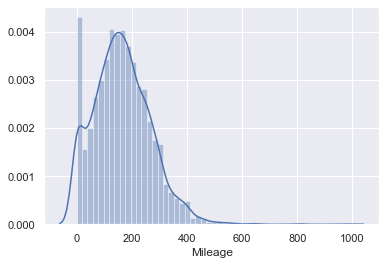

In [106]:
#Checking PDFs for another variable
sns.distplot(df["Mileage"])

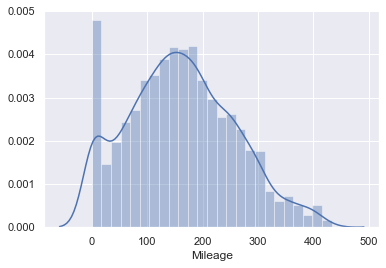

In [107]:
#Same thing happened for Mileage, EngineV and Year. There are few outliers. So the same produre will be appplied:
q = data['Mileage'].quantile(0.99)
df= df.loc[data["Mileage"]<q,:]
sns.distplot(df["Mileage"])

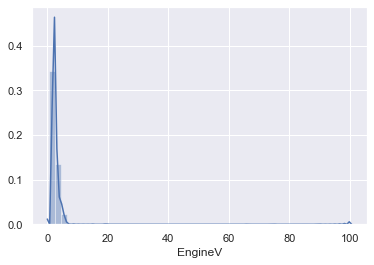

In [108]:
# For engine volume, the situation with engine volume is very strange
# In such cases it makes sense to manually check what may be causing the problem
sns.distplot(df["EngineV"])

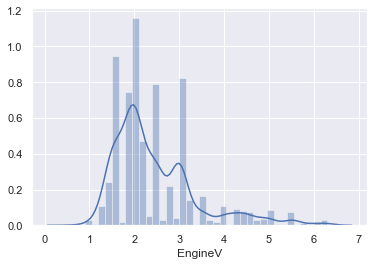

In [109]:
# In our case the issue comes from the fact that most missing values are indicated with 99.99 or 99
# There are also some incorrect entries like 75
# A quick search on google indicates that the max engine volume can go is 6.5
# So we will only take into account the data with engine v < 6.5

df= df.loc[df["EngineV"]<6.5,:]
sns.distplot(df["EngineV"])

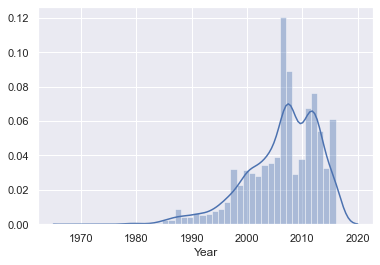

In [110]:
# Check PDFs Year
sns.distplot(df["Year"])

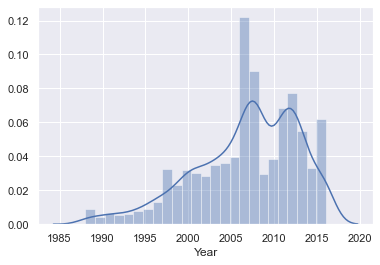

In [111]:
# Most of them are newer car but there are some old and classic car
#To deal with this, we will declare a variable that will be equal to the 1st percentile of the 'Year' variable and will keep those that are high
q=df["Year"].quantile(0.01)
df = df.loc[df["Year"]>q,:]
sns.distplot(df["Year"])

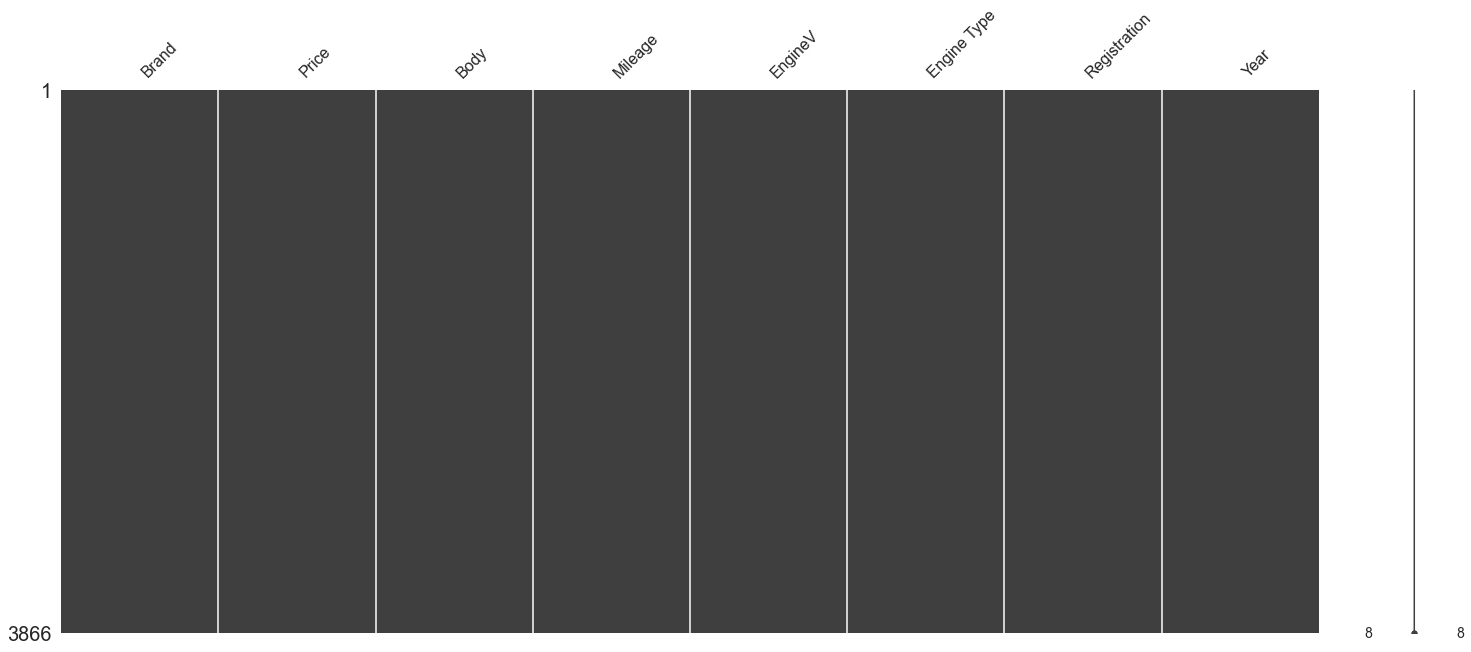

In [112]:
#Visualising the cleaned data and save it
msno.matrix(df)

In [113]:
#Assigning the df into cleaned data
cleaned_data = df

In [114]:
#Save
#cleaned_data.to_csv("cleaned_data", index=False)

In [115]:
# Re load the cleaned data into the environment 
df=pd.read_csv("cleaned_data")
df

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011
...,...,...,...,...,...,...,...,...
3861,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008
3862,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014
3863,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014
3864,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999


In [116]:
df.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3866,3866.000000,3866,3866.000000,3866.000000,3866,3866,3866.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,848,NaN,1466,NaN,NaN,1807,3504,NaN
mean,NaN,18197.480629,NaN,160.471547,2.450246,NaN,NaN,2006.713140
std,NaN,19087.396949,NaN,95.543697,0.949413,NaN,NaN,6.101235
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


## Checking the Ordinary Least Square Assumptions. 

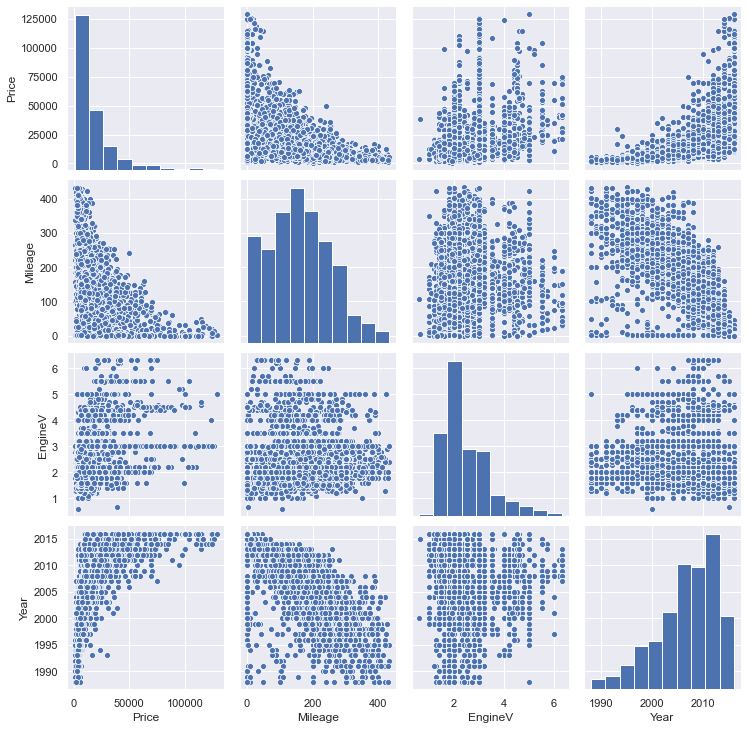

In [117]:
# We need to check for the numerical variable. In our case: Price, Year, EngineV and Mileage
sns.pairplot(df)

Looking at the first row of the pairplot and the PDF of price,  we can easily determine that 'Price' is exponentially distributed. A good transformation in that case is a log transformation because we cannot run Linear regression on a not linear relationship

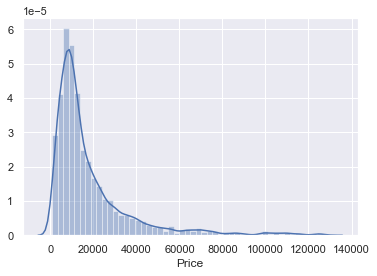

In [118]:
sns.distplot(df["Price"])

### OLS Assumptions 

#### Transforming Price attribute using Log Transformation

In [119]:
# Transform Price to log_price
log_price=np.log(df["Price"])

#Store it as a new variable
df["Log Price"]=log_price
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Log Price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656


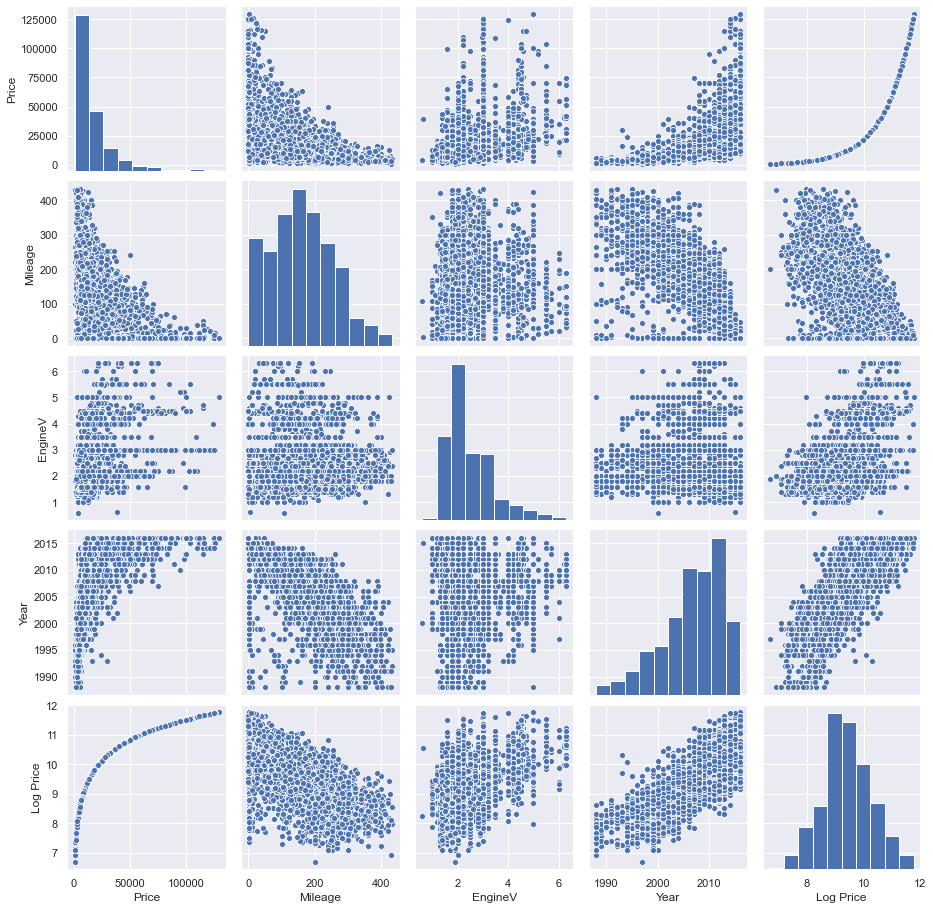

In [120]:
# Re-plot the pair plot to observe the relationship of Log-Price with other features
sns.pairplot(df)

As shown, we can see the linear pattern across all features. (Focus on the last row of the graph only). The line fits the data much better- Linear relationship 

- The relationships show a clear linear relationship
- This is some good linear regression material
- Alternatively we could have transformed each of the independent variables

In [121]:
# Since the column Price is no longer needed, we can drop it
df=df.drop(["Price"],axis=1)
df.head(2)

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Log Price
0,BMW,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,8.974618


### Checking for multicollinearity

In [122]:
# Logically, Year and Mileage will be correlated because the higher the Year and the higher the Mileage, it will results to lower sale price

In [123]:
df.columns

Index(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type', 'Registration',
       'Year', 'Log Price'],
      dtype='object')

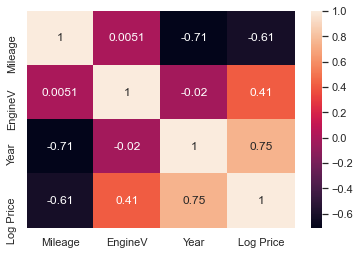

In [124]:
# Visualising correlation matrix
corrMatrix=df.corr()
ax=plt.subplot(111)
sns.heatmap(corrMatrix, ax=ax, annot=True)

In [125]:
#One of the best ways to check for multicollinearity is by using cariance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Define features that we want to check for multicollinearity
variables = df[["Mileage", "Year", "EngineV"]]

# Creating a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Assigning the features
vif["Features"] = variables.columns

The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.

One recommendation is that if VIF is greater than 5, then the explanatory
variable given by exog_idx is highly collinear with the other explanatory
variables, and the parameter estimates will have large standard errors
because of this.

Further explaination can be get here: https://www.statsmodels.org/dev/_modules/statsmodels/stats/outliers_influence.html#variance_inflation_factor

In [126]:
vif

,VIF,Features
0,3.794319,Mileage
1,10.360888,Year
2,7.660317,EngineV


As you can see here, Year attribute has the highest VIF. Therefore, we should remove it. Even though EngineV seems to have high VIF too (more than 5), once 'Year' is gone it will not longer be a serious case!

In [127]:
# Dropping "Year" attribute
df = df.drop(['Year'],axis=1)
df.head(2)

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Log Price
0,BMW,sedan,277,2.0,Petrol,yes,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,8.974618


## Pre-processing the categorical data - Create Dummy Variables

In [132]:
# Im using pd.get_dummies to spot all categorical variable and creates dummies automatically
# Note that if we have N categories for a feature, we have to create N-1 dummies.
# Exploring our categorical features
print(df["Brand"].unique())
print(df["Body"].unique())
print(df["Engine Type"].unique())

['BMW' 'Mercedes-Benz' 'Audi' 'Toyota' 'Renault' 'Volkswagen' 'Mitsubishi']
['sedan' 'van' 'crossover' 'vagon' 'other' 'hatch']
['Petrol' 'Diesel' 'Gas' 'Other']


As we can see, the categorical variables have N categories (more category such as BMW, Audi, Toyota, Seda, Van, Petrol, Diesel, etc.) for each column.

In [133]:
# So we will create dummies with N-1 where we will define it as drop_first= True
df = pd.get_dummies(df, drop_first=True)
df

,Mileage,EngineV,Log Price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,163,2.5,9.350102,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3862,35,1.6,9.792556,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1
3863,9,3.0,11.736069,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3864,1,3.5,8.779557,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1


### Rearrange the Data  

In [135]:
df.columns.values

array(['Mileage', 'EngineV', 'Log Price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [136]:
# Rearrange the colums
# Conventionally, the most intuitive order is: dependent variable, indepedendent numerical variables, dummies
cols= ['Log Price','Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

In [138]:
df=df[cols]

In [140]:
df.head()

,Log Price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


# Modeling - Linear Regression

### Declare the inputs and the target variable

In [141]:
# Declare features and target variable

# The target(s) (dependent variable) is Log Price
targets = df["Log Price"]

# The inputs are everything BUT not the dependent variable, so we can simply drop Log Price
inputs = df.drop(["Log Price"],axis=1)

### Scaling the Data

In [155]:
# It is best if we can standardised the data in order to center the variables so that the predictors have mean 0
# To do this, we use Standard Scaler 
 
from sklearn.preprocessing import StandardScaler

# Scale the input variable:
scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler()

In [156]:
# Scale the features and store them in a new variable (the actual scaling procedure)
scaled_inputs = scaler.transform(inputs)

### Now Spliting the Data into Train Test Split

In [226]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with 80-20 split and some random state
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size=0.2, random_state=42)

### Create the Regression Model

### Training

In [227]:

# Model the data
model = LinearRegression()
model.fit(X_train, y_train) #(Training input, training target)

LinearRegression()

In [228]:
#Now we will predict our value using the model
# y_model = y_hat
y_hat = model.predict(X_train) # We are predicting based on the training data set to see whether y_hat(predicted) similar or not to y_train (training target)

In [229]:
#yhat = b0+b1X1+b2X2+.....+bkXk --- Multiple Linear Regression formula

Now, we will check the final result by plotting the predicted value against the observed values (Training Target).

It should be if the targetted value is 7, the predicted should be 7. If targetted 10, predictions should be 10

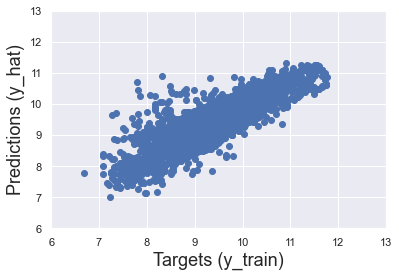

In [230]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

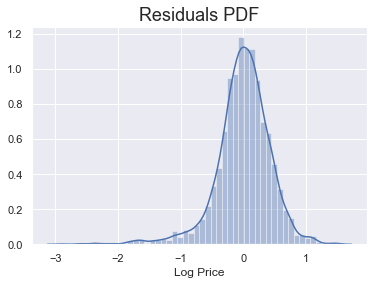

In [231]:
# Now we will try to plot residual plots - It will show the differences between the target and the predictions
# We can plot the PDF of the residuals and check for anomalies
# Residual plots also will give a sign whether we should improve our model or not
sns.distplot(y_train - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)


In the best case scenario this plot should be normally distributed. In this case, we notice that there are many negative residuals (far away from the mean). Given the definition of the residuals (y_train - y_hat), negative values imply that y_hat (predictions) are much higher than y_train (the targets). 

### Finding Statistic Values from the model

#### R^2

In [232]:
model.score(X_train, y_train)

0.752798334452781

#### Adj- R^2


$R^2_{adj.} = 1-(1-R^2)*\frac{n-1}{n-p-1} $

where
n = number of observations , 
p= number of predictors (feature column)

In [233]:
X_train.shape

(3092, 17)

In [234]:
r2=model.score(X_train, y_train)
n=X_train.shape[0]
p=X_train.shape[1]
adj_r2= 1-(1-r2)*(n-1)/(n-p-1)
adj_r2

0.7514312465170937

A good linear regression model should have R^2 value that is higher than adj R^2. We are seems okay for that. 

#### Finding Weight and Bias

In [235]:
model.intercept_

9.417655717209573

In [236]:
model.coef_

array([-0.45954324,  0.21949194,  0.01040878,  0.00286894, -0.14016001,
       -0.18442074, -0.06467445, -0.09142259, -0.14072592, -0.09761333,
       -0.18770557, -0.11970774, -0.15476602, -0.12318859, -0.03168792,
       -0.15364747,  0.32075575])

In [237]:
# Creating Model Summary based on the intercept and coeffiecient values

model_summary = pd.DataFrame(inputs.columns.values, columns=["Features"])
model_summary["Weights"]= model.coef_
model_summary

,Features,Weights
0,Mileage,-0.459543
1,EngineV,0.219492
2,Brand_BMW,0.010409
3,Brand_Mercedes-Benz,0.002869
4,Brand_Mitsubishi,-0.140160
5,Brand_Renault,-0.184421
6,Brand_Toyota,-0.064674
7,Brand_Volkswagen,-0.091423
8,Body_hatch,-0.140726
9,Body_other,-0.097613


Interpreting the Weights Value:
    1. A positive weight shows that as a feature increases in value, the price will go increase
    2. A negative weight shows that as a feature increases in negative value, the price will go decrease
    
Previously, we have created N-1 dummy variables where we have excluded Audi. This will infer that Audi is the benchmark in our case.

Whenever all other dummies are zero, that means Audi is 1.

Interpreting the dummy variables from weights:
    1. A positive weight shows the respective category car Brand is more expensive than the benchmark(Audi)
        Example: BMW and Merc-Benz are more expensive than Audi
    2. A negative weight shows the respective category car Brand is more cheaper than the benchmark (Audi)
        Example: Mitsubishi and Toyota are more much cheaper than Audi

### Testing

In [238]:
# Now we will perform model testing using the testing dataset.
y_hat_test = model.predict(X_test)

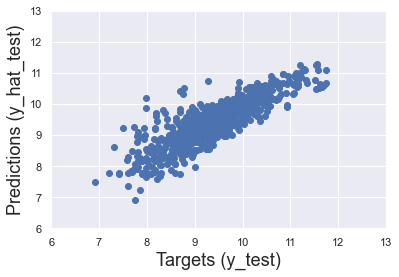

In [239]:
#Plotting the model testing
plt.scatter(y_test, y_hat_test)
# Let's also name the axes
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

It seems that our model are good at predicting the car price at higher price. But for the lower price, it seems scattered

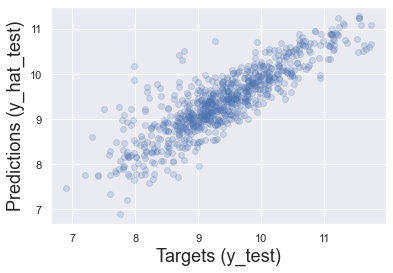

In [240]:
#To examine that, I will add the alpha to create the opacity to see which place are concentrated or not
# Replotting

plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)

plt.show()

Now, the model actually looks good on predicting lower or higher price because the concentration are linear.

#### Testing the Model Performance

In [241]:
df_perf= pd.DataFrame((y_hat_test), columns=["Predictions"])
df_perf

,Predictions
0,9.339494
1,9.861483
2,8.634573
3,10.528974
4,8.884685
5,9.994023
6,8.457944
7,9.002881
8,10.639597
9,11.274847


This model predict **log Price**. We want it to predict real price. Now, we need to change it:
    

In [194]:
# To obtain the actual prices, we take the exponential of the log_price
# Using np.exp(x) to return the exponetial of x
df_perf= pd.DataFrame(np.exp(y_hat_test), columns=["Predictions"])
df_perf

,Predictions
0,10650.438709
1,8041.555683
2,6799.069945
3,7606.977689
4,11309.799759
...,...
769,14874.949923
770,5735.556226
771,13623.775492
772,28096.133846


In [196]:
# We can also include the test targets in that data frame (so we can manually compare them)
df_perf['Target'] = np.exp(y_test)
df_perf



,Predictions,Target
0,10650.438709,NaN
1,8041.555683,7900.0
2,6799.069945,NaN
3,7606.977689,NaN
4,11309.799759,NaN
...,...,...
769,14874.949923,6950.0
770,5735.556226,NaN
771,13623.775492,NaN
772,28096.133846,NaN


In [197]:
# Note that we have a lot of missing values. This is because Python try to match the index value of the training dataset. 
# We inspect:
y_test

1192     7.740664
2752     9.487972
3752     8.999619
3256     8.764053
892      9.121509
          ...    
2044    10.292146
2957     8.575462
3133     9.814656
1369    11.134589
2594     9.287301
Name: Log Price, Length: 774, dtype: float64

In [198]:
# So we need to reset the index
y_test = y_test.reset_index(drop=True)

# Now we re-create our comparison table
df_perf['Target'] = np.exp(y_test)
df_perf

,Predictions,Target
0,10650.438709,2300.0
1,8041.555683,13200.0
2,6799.069945,8100.0
3,7606.977689,6400.0
4,11309.799759,9150.0
...,...,...
769,14874.949923,29500.0
770,5735.556226,5300.0
771,13623.775492,18300.0
772,28096.133846,68500.0


In [204]:
# Additionally, we can calculate the difference between the targets and the predictions
# Note that this is actually the residual 

df_perf["Residuals"]=df_perf["Target"]-df_perf["Predictions"]

# We also can calculate the percentage difference between the targetted and predicted values. Make sure it return as absolute
df_perf['Percentage %'] = np.absolute(df_perf['Residuals']/df_perf['Target']*100)

# Show
df_perf

,Predictions,Target,Residuals,Percentage %
0,10650.438709,2300.0,-8350.438709,363.062553
1,8041.555683,13200.0,5158.444317,39.079124
2,6799.069945,8100.0,1300.930055,16.060865
3,7606.977689,6400.0,-1206.977689,18.859026
4,11309.799759,9150.0,-2159.799759,23.604369
...,...,...,...,...
769,14874.949923,29500.0,14625.050077,49.576441
770,5735.556226,5300.0,-435.556226,8.218042
771,13623.775492,18300.0,4676.224508,25.553139
772,28096.133846,68500.0,40403.866154,58.983746


In [205]:
# Exploring the descriptives here gives us additional insights
df_perf.describe()

,Predictions,Target,Residuals,Percentage %
count,774.000000,774.000000,774.000000,774.000000
mean,16170.746881,18612.010504,2441.263622,33.814041
std,13742.956902,20953.006281,10835.145339,48.272151
min,1284.843010,1400.000000,-29171.365746,0.056793
25%,7489.039002,6999.250000,-2013.351405,11.277214
50%,11561.730997,11500.000000,150.474574,23.239276
75%,19726.158072,20500.000000,3293.698161,39.023878
max,77447.771561,124000.000000,80642.598057,507.418465


In [210]:
#Since Pandas does not show all records, we can tune it to display all the records

pd.options.display.max_rows=999

#Sort the values by percentage %
df_perf.sort_values("Percentage %") 

,Predictions,Target,Residuals,Percentage %
264,11493.468837,11500.00,6.531163,0.056793
742,16985.248181,16999.00,13.751819,0.080898
60,12486.363039,12500.00,13.636961,0.109096
127,23257.548035,23200.00,-57.548035,0.248052
308,8876.915349,8900.00,23.084651,0.259378
242,7478.348510,7500.00,21.651490,0.288687
698,30600.222849,30500.00,-100.222849,0.328600
379,17733.154392,17800.00,66.845608,0.375537
114,27429.729872,27300.00,-129.729872,0.475201
317,11560.121320,11500.00,-60.121320,0.522794


## Model Evaluation and Conclusion

#### R^2 for Training Dataset

In [257]:
from sklearn.metrics import r2_score
r2_test= r2_score(y_test, y_hat_test)
r2_test

0.7432208488378995

In [251]:
import math

from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(y_test,y_hat_test))
rmse

0.43426316198842485

In [254]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, y_hat_test)
mae

0.3172256618975854

In [258]:
ME = pd.DataFrame([["R-squared - Train"],["R-squared - Test"], ["Adjusted - R squared"], ["Root Mean SquareError"], ["Mean Absolute Error"]], columns=["Feature"])
ME["Value"]= [r2,r2_test, adj_r2, rmse, mae]
ME

,Feature,Value
0,R-squared - Train,0.752798
1,R-squared - Test,0.743221
2,Adjusted - R squared,0.751431
3,Root Mean SquareError,0.434263
4,Mean Absolute Error,0.317226


Looking at the R^2 value and adj-R^2 value, the performance of Linear Regression Model are pretty acceptable. Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately. In addition, Adjusted R-squared of more than 0.75 is a very good value for showing the accuracy.

To answer our question whether is it possible to predict the price of used car with their specifications, the anwer is Yes! Linear Regression model is pretty decent at predicting the used car price. But there are some records where the percentage difference of the predicted price are far from the targetted price. This is maybe because we didn't include any other features that governed the price to be much lowered. 

**Assumptions that can be made**:
- It can be the model of the car, which we removed it at the beginning (Because of too much variations)
- It can be that the car is damaged in some way because this is a real used car data. Not all conditions of used car are good. In fact, there is no column for declaring the condition of the car. 

**Suggestions in improving the model**:

- Use different set of variables
- Remove thr bigger part of the outliers
- Use another types of transformations 